In [1]:
from dynamics import *
from problem import *
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 

In [2]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a single quadrotor:

In [5]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 0.5, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*100

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])
N = 100
n_agents = 1
n_states = 6
n_inputs = 3
# Qs = [Q] * n_agents
# Rs = [R] * n_agents
# Qfs = [Qf] * n_agents
# x_dims = [n_states]*n_agents
# u_dims = [n_inputs]*n_agents
opti = Opti()
T = opti.variable()
dt = T/N

In [6]:
# models = [quad6D,quad6D,quad6D]

In [7]:
# ids = [i for i in range(n_agents)]

In [8]:
# quad6D(xf,Q,R,Qf,u_ref,N).cost()

In [9]:
#  = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [10]:
# problem = quadProblem()

In [11]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [13]:
# x_dims = [6,6,6,6]

In [14]:
g = 9.81

In [15]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan([0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [16]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps


In [17]:
total_stage_cost = 0
for j in range(X.shape[1]):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
for j in range(X.shape[1]):
    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,j]-xf[i])*Qf[i, i]*(X[i,j]-xf[i])

In [18]:
objective = total_terminal_cost + total_stage_cost


In [19]:
opti.minimize(objective) 

In [20]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=20) # tau is limited
opti.subject_to(9.8<=U[2,:]) #minimum force keeps the drone at hover

opti.subject_to(T>=0) #time must be positive

#equality constraints:
opti.subject_to(X[:,0] == x0)

#initial values for solver
opti.set_initial(T, 0)

opti.solver("ipopt")
sol = opti.solve()



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2506
Number of nonzeros in inequality constraint Jacobian.:     1207
Number of nonzeros in Lagrangian Hessian.............:     1405

Total number of variables............................:      907
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality co

In [21]:
print(sol.value(X).shape)

(6, 101)


In [22]:
X_trj = sol.value(X)
U_trj = sol.value(U)

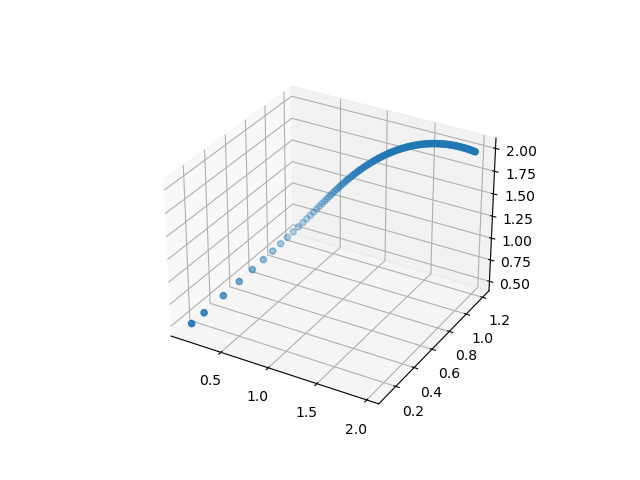

In [23]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])


In [24]:
U_trj[0,:]

array([ 9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  9.85003811e-26,  9.85003811e-26,  9.85003811e-26,
        9.85003811e-26,  

In [25]:
U_trj[1,:]

array([-4.60049438e-01,  9.59188578e-02,  7.92168596e-02,  6.53931566e-02,
        5.39702692e-02,  4.45362694e-02,  3.67476963e-02,  3.03191574e-02,
        2.50140608e-02,  2.06365787e-02,  1.70247974e-02,  1.40449409e-02,
        1.15865356e-02,  9.55838166e-03,  7.88520797e-03,  6.50489944e-03,
        5.36620307e-03,  4.42683153e-03,  3.65189650e-03,  3.01261502e-03,
        2.48524161e-03,  2.05018693e-03,  1.69129052e-03,  1.39522069e-03,
        1.15097941e-03,  9.49493895e-04,  7.83279532e-04,  6.46161928e-04,
        5.33047541e-04,  4.39734476e-04,  3.62756402e-04,  2.99253784e-04,
        2.46867668e-04,  2.03652045e-04,  1.68001569e-04,  1.38591916e-04,
        1.14330594e-04,  9.43163572e-05,  7.78057294e-05,  6.41853832e-05,
        5.29493579e-05,  4.36802643e-05,  3.60337795e-05,  2.97258565e-05,
        2.45221721e-05,  2.02294230e-05,  1.66881446e-05,  1.37667877e-05,
        1.13568313e-05,  9.36875181e-06,  7.72869723e-06,  6.37574376e-06,
        5.25963268e-06,  